## 分析：売上と運営状況の関係を多面的に可視化する

- 前処理済みのファイル `summary_df.csv` を読み込む

- アプリごとに以下の観点で可視化を行う

  - **観測月数と売上合計の関係**  
    └ 傾向を視覚化し、運営期間と売上規模の相関を確認する

  - **売上統計（最大月・中央値）の分布**  
    └ 売上パターンのばらつきを把握し、特徴を探る

  - **売上の空白期間（終了日とのギャップ）分析**  
    └ 最終売上からサービス終了までの期間を可視化し、失速傾向を捉える

  - **減衰率（初期⇔末期売上）の分布とサービス終了の関連性**  
    └ 売上の衰退スピードと終了リスクの関係性を分析

    
- 継続期間・売上規模・減衰傾向から、  
  **終了リスクの条件**を総合的に探る

- IPと非IPに分類し，サービス終了の傾向を比較

### 1.1. ライブラリとデータ読み込み

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ファイル読み込み（必要に応じてパスを調整）
summary_df = pd.read_csv("summary_df.csv")

# 表示設定（任意）
plt.rcParams["font.family"] = "Meiryo"  # 日本語対応

### 1.2. 観測月数×売上合計の散布図

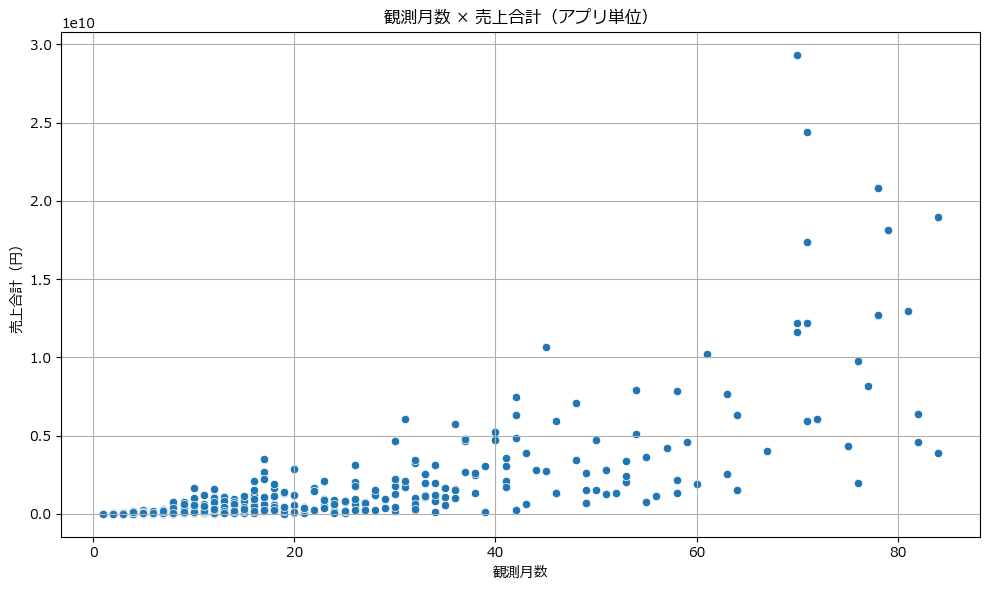

In [2]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=summary_df, x="観測月数", y="売上合計")
plt.title("観測月数 × 売上合計（アプリ単位）")
plt.xlabel("観測月数")
plt.ylabel("売上合計（円）")
plt.grid(True)
plt.tight_layout()
plt.show()

### 1.3.対数スケールによる再描画
- 売上合計が一部のアプリで極端に大きいため，`log`スケールで縦軸補正

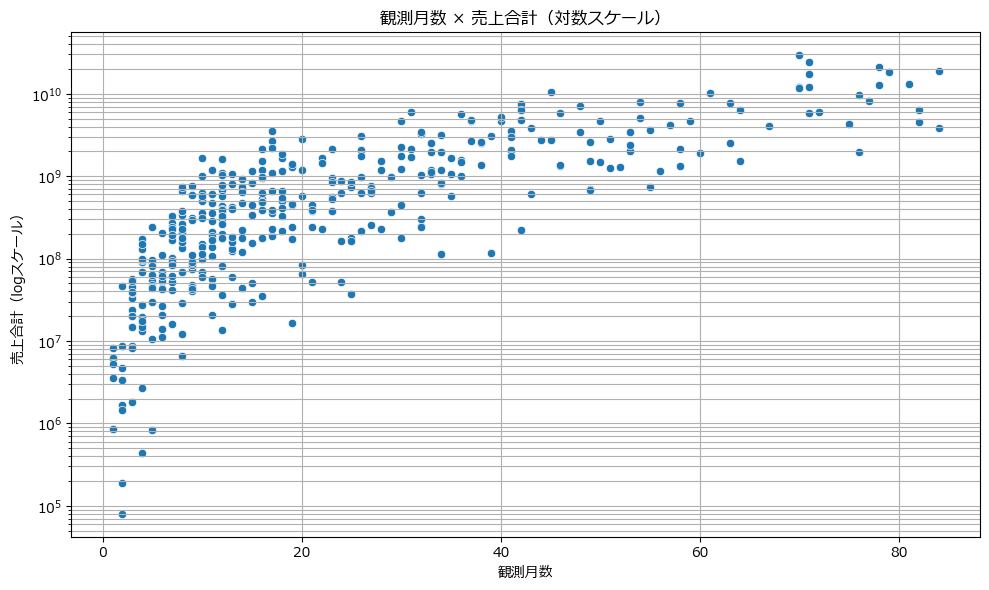

In [3]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=summary_df, x="観測月数", y="売上合計")
plt.yscale("log")
plt.title("観測月数 × 売上合計（対数スケール）")
plt.xlabel("観測月数")
plt.ylabel("売上合計（logスケール）")
plt.grid(True, which="both")
plt.tight_layout()
plt.show()

### 2.1. 終了日前の空白期間を可視化

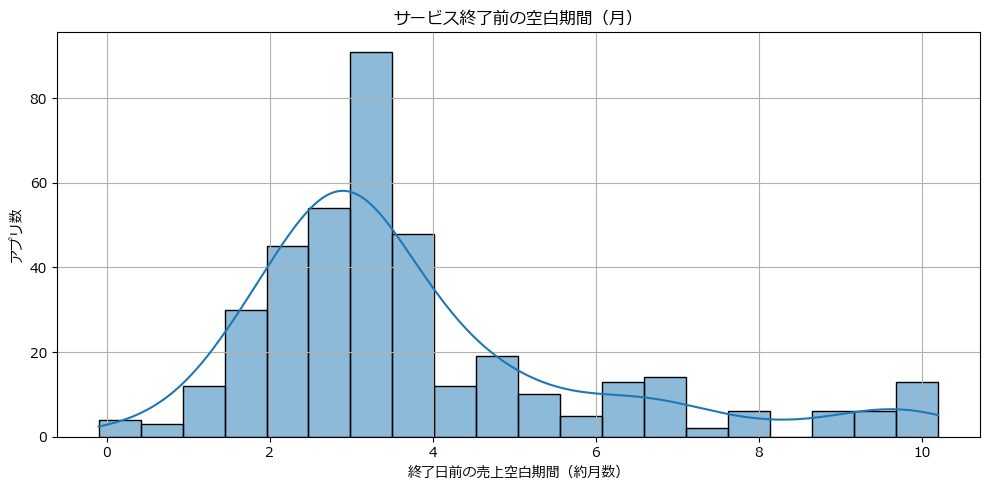

In [4]:
# 日付型に変換（必要なら）
summary_df["最終売上月"] = pd.to_datetime(summary_df["最終売上月"], format="%Y-%m")
summary_df["サービス終了日"] = pd.to_datetime(summary_df["サービス終了日"], format="%Y/%m/%d")

# 差分（月単位に丸める）
summary_df["空白期間（月）"] = ((summary_df["サービス終了日"] - summary_df["最終売上月"]) / pd.Timedelta(days=30)).round(1)

# 可視化（ヒストグラム）
plt.figure(figsize=(10, 5))
sns.histplot(summary_df["空白期間（月）"], bins=20, kde=True)
plt.title("サービス終了前の空白期間（月）")
plt.xlabel("終了日前の売上空白期間（約月数）")
plt.ylabel("アプリ数")
plt.grid(True)
plt.tight_layout()
plt.show()

### 2.2 観測月数×売上合計×空白期間の3変数プロット(バブル図)

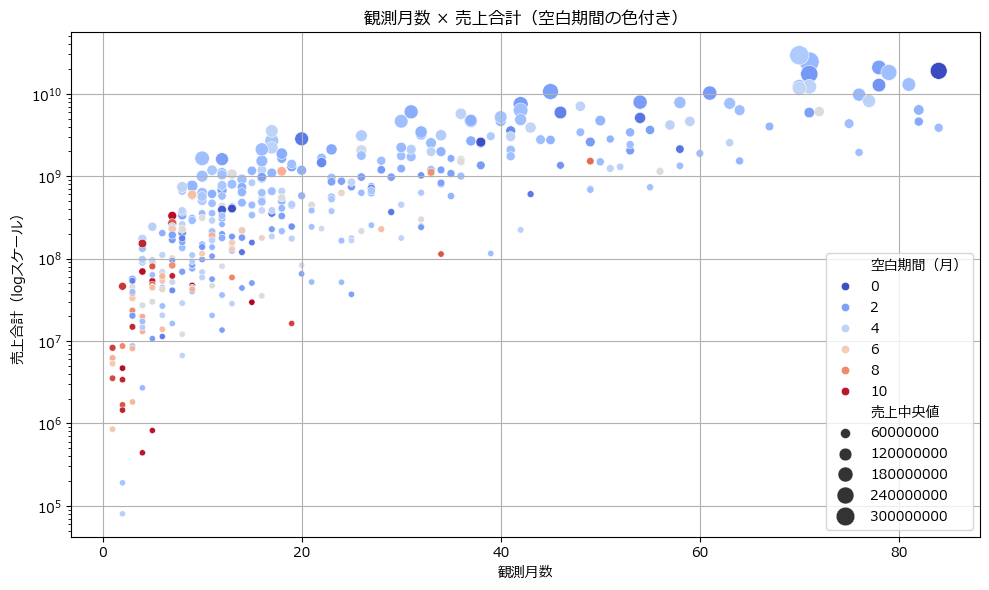

In [5]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=summary_df,
    x="観測月数",
    y="売上合計",
    hue="空白期間（月）",  
    palette="coolwarm",
    size="売上中央値",
    sizes=(20, 200)
)
plt.yscale("log")
plt.title("観測月数 × 売上合計（空白期間の色付き）")
plt.xlabel("観測月数")
plt.ylabel("売上合計（logスケール）")
plt.grid(True)
plt.tight_layout()
plt.show()

### 2.3 売上指標の基本統計量確認

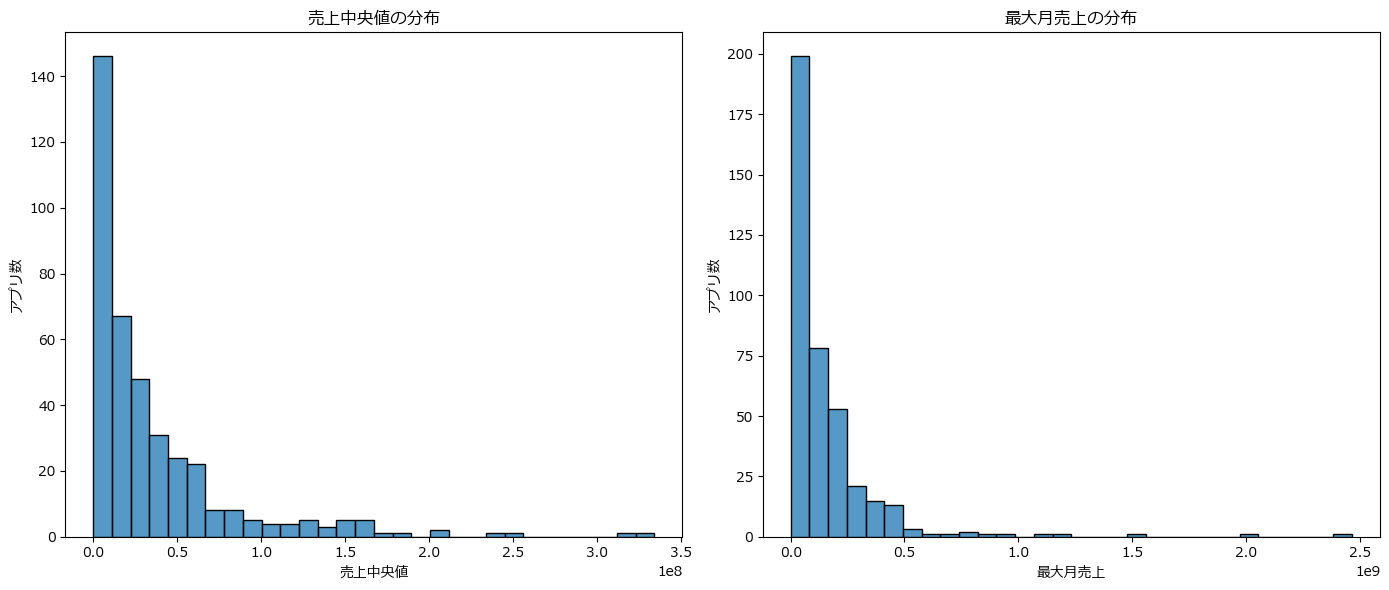

In [6]:
# ヒストグラムや箱ひげ図で中央値・最大月売上の分布を確認
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.histplot(summary_df["売上中央値"], bins=30, ax=axes[0])
axes[0].set_title("売上中央値の分布")
axes[0].set_ylabel("アプリ数")

sns.histplot(summary_df["最大月売上"], bins=30, ax=axes[1])
axes[1].set_title("最大月売上の分布")
axes[1].set_ylabel("アプリ数")

plt.tight_layout()
plt.show()

### 2.4.　減衰率(終了3か月売上平均/開始3か月売上平均)の可視化

In [7]:
from decimal import Decimal

# 月次売上のオリジナルデータ（cleaned_output.csv）を読み込み
monthly_df = pd.read_csv("cleaned_output.csv")

# 必要な列を確認しておく
monthly_df = monthly_df[["タイトル", "年月", "売上予測（円）"]]

# 日付型に変換
monthly_df["年月"] = pd.to_datetime(monthly_df["年月"], format="%Y/%m")

In [8]:
# アプリごとに最小〜最大年月を取得
date_ranges = monthly_df.groupby("タイトル")["年月"].agg(["min", "max"]).reset_index()

# 全アプリについて、月次の連続期間を作成
all_records = []

for _, row in date_ranges.iterrows():
    title = row["タイトル"]
    start = row["min"]
    end = row["max"]
    date_range = pd.date_range(start=start, end=end, freq="MS")  # 月初ごと
    for date in date_range:
        all_records.append({"タイトル": title, "年月": date})

full_df = pd.DataFrame(all_records)

# 元データとマージして、欠損を NaN として明示
merged_df = pd.merge(full_df, monthly_df, on=["タイトル", "年月"], how="left")

In [9]:
# 補完用の列（移動平均で補完、妥当性は記事で）
merged_df["補完売上"] = merged_df.groupby("タイトル")["売上予測（円）"].transform(
    lambda x: x.fillna(x.rolling(window=3, min_periods=1).mean())
)

In [10]:
# アプリごとに初期・末期の平均を計算
def compute_decay(group):
    group = group.sort_values("年月")
    early = group["補完売上"].head(3).mean()
    late = group["補完売上"].tail(3).mean()
    decay = round((late / early), 2) if early != 0 else None
    return pd.Series({
        "初期平均": early,
        "末期平均": late,
        "減衰率（末期÷初期）": decay
    })

decay_df = (
    merged_df
    .groupby("タイトル", group_keys=False)
    .apply(lambda g: compute_decay(g.drop(columns="タイトル")))
    .reset_index()
)


C:\Users\zakky\AppData\Local\Temp\ipykernel_10520\1112764308.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: compute_decay(g.drop(columns="タイトル")))


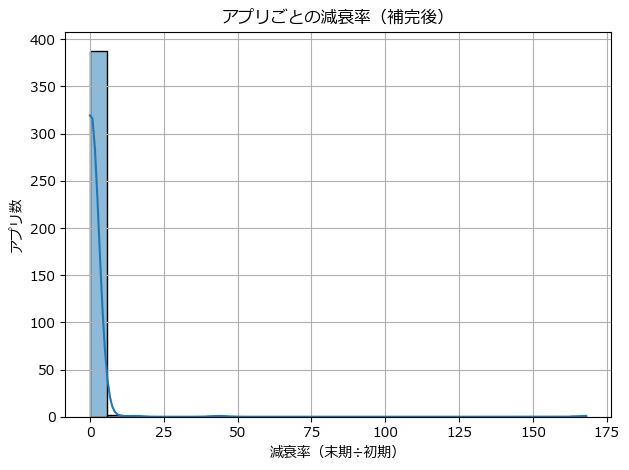

In [11]:
sns.histplot(decay_df["減衰率（末期÷初期）"], bins=30, kde=True)
plt.title("アプリごとの減衰率（補完後）")
plt.xlabel("減衰率（末期÷初期）")
plt.ylabel("アプリ数")
plt.grid(True)
plt.tight_layout()
plt.show()

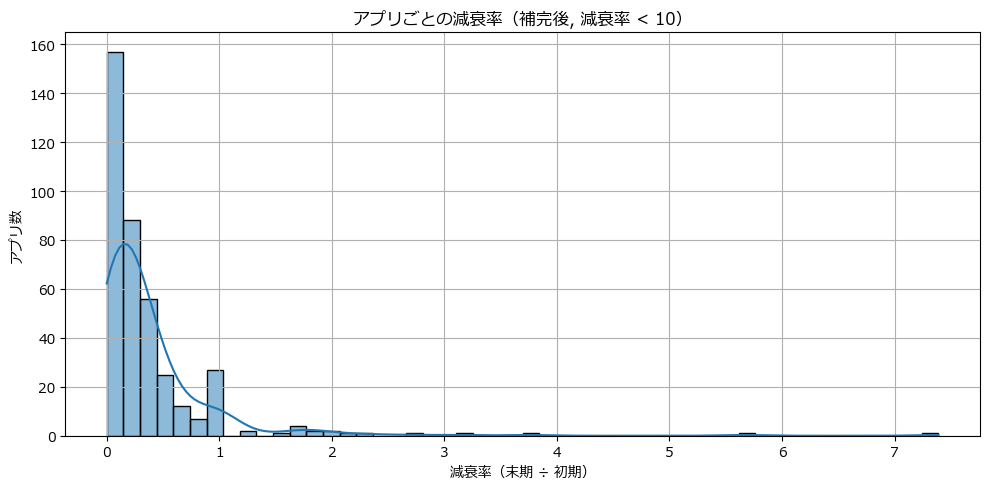

In [12]:
# 正しい列名でフィルタ
filtered = decay_df[decay_df["減衰率（末期÷初期）"] < 10]

plt.figure(figsize=(10, 5))
sns.histplot(filtered["減衰率（末期÷初期）"], bins=50, kde=True)
plt.title("アプリごとの減衰率（補完後, 減衰率 < 10）")
plt.xlabel("減衰率（末期 ÷ 初期）")
plt.ylabel("アプリ数")
plt.grid(True)
plt.tight_layout()
plt.show()

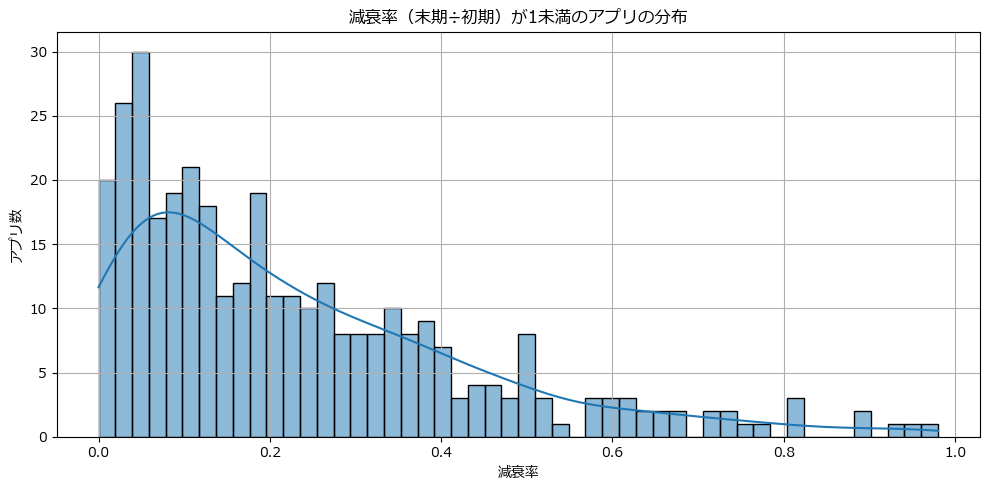

In [13]:
filtered = decay_df[decay_df["減衰率（末期÷初期）"] < 1.0]
plt.figure(figsize=(10, 5))
sns.histplot(filtered["減衰率（末期÷初期）"], bins=50, kde=True)
plt.title("減衰率（末期÷初期）が1未満のアプリの分布")
plt.xlabel("減衰率")
plt.ylabel("アプリ数")
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
# ビン作成（0〜1の範囲で0.1刻み）
bins = pd.interval_range(start=0, end=1.0, freq=0.1, closed="left")
decay_df["減衰率ビン"] = pd.cut(decay_df["減衰率（末期÷初期）"], bins=bins)

# 終了済み数と総数
grouped = decay_df.groupby("減衰率ビン")["終了済み"].agg(["count", "sum"])
grouped.index = grouped.index.map(lambda x: f"{x.left:.1f}–{x.right:.1f}")

# プロット
fig, ax1 = plt.subplots(figsize=(10, 5))

# アプリ総数（棒）
grouped["count"].plot(kind="bar", color="lightgray", ax=ax1, position=0, width=0.4, label="アプリ総数")
ax1.set_ylabel("アプリ数", color="gray")
ax1.tick_params(axis="y", labelcolor="gray")
ax1.set_xlabel("減衰率（末期 ÷ 初期）ビン")
plt.xticks(rotation=45, ha="right")

# 終了数（折れ線）
ax2 = ax1.twinx()
grouped["sum"].plot(kind="line", color="coral", marker="o", ax=ax2, label="終了済みアプリ数")
ax2.set_ylabel("終了済み数", color="coral")
ax2.tick_params(axis="y", labelcolor="coral")

# タイトル・凡例
plt.title("減衰率ごとのアプリ数と終了数（0〜1の範囲）")
fig.tight_layout()
plt.show()


C:\Users\zakky\AppData\Local\Temp\ipykernel_10520\1661143433.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = decay_df.groupby("減衰率ビン")["終了済み"].agg(["count", "sum"])


KeyError: 'Column not found: 終了済み'

### 2.6. IPと非IPの比較

IP分類
非IP    283
IP     110
Name: count, dtype: int64


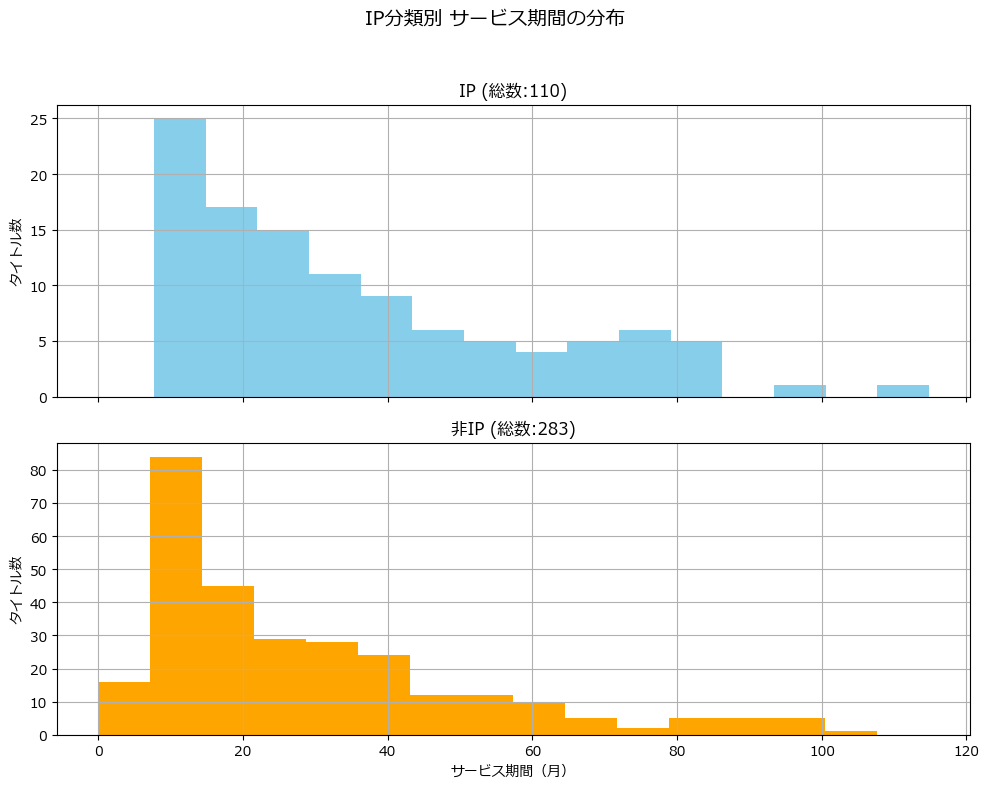

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
# ファイル読み込み（年月・売上予測は除外）
df = pd.read_csv("merged_and_ordered.csv")
df = df.drop(columns=["年月", "売上予測（円）"], errors="ignore")   # errors="ignore":エラーが出てもスルーして処理

# タイトルごとに1行に統合（発売日最小、終了日は最大）
#aggregated = df.groupby("タイトル", as_index=False).agg({      # as_index=False:通常列として残す　Trueならindex
    # "発売日": "min",                                          # .agg():集約処理　例：.agg({"売上"："sum"})
    # "サービス終了日": "max",
    # "備考": "first"
#})                                                             # 今回は同一タイトルのカラム内容は全一致しているから.agg()は不要

# aggregated = df.drop_duplicates(subset=["タイトル"])          # タイトルが同じ場合,最初の1行を残す

aggregated = df.drop_duplicates().copy()    # 全列の完全一致で重複を削除


# IP/非IPの分類
def classify_ip(text):  
    if pd.isna(text):   
        return "非IP"
    if any(keyword in text for keyword in ["アニメ", "コミック", "原作", "マンガ", "漫画", "小説"]): 
        return "IP"
    return "非IP"
# pd.isna():引数がNaNならばreturn返す → 備考欄がNaNのときfloatだからこれしないとエラー, any():1つでもTrueなら

aggregated["IP分類"] = aggregated["備考"].apply(classify_ip)  
# dfの備考列を取り出して.その列の各行に定義した関数を適用(apply():列に対して各要素を処理)しIP分類列を新たに作る

# 日付の整形
aggregated["発売日"] = pd.to_datetime(aggregated["発売日"], errors="coerce")
aggregated["サービス終了日"] = pd.to_datetime(aggregated["サービス終了日"], errors="coerce") 
# 差分計算のためdatetime型に変換, errors="coerce": 変換に失敗したときは NaT（欠損値のような日付）にするオプション

# サービス継続期間（月単位）
aggregated["サービス期間（月）"] = ((aggregated["サービス終了日"] - aggregated["発売日"]) / pd.Timedelta(days=30)).round(1)
# 日付の除法はTimedelta型 　round(1):小数第一位で丸める

# 有効な期間データのみ抽出→欠損補完しているから不要
# aggregated = aggregated.dropna(subset=["サービス期間（月）"])  subset:特定の列だけチェック

# 件数を含むラベルに変換
# counts = aggregated["IP分類"].value_counts()
# label_map = {k: f"{k} (n={v})" for k, v in counts.items()}
# aggregated["分類ラベル"] = aggregated["IP分類"].map(label_map)

counts = aggregated["IP分類"].value_counts() #valuse_counts():列にどの値が何回でてきたか
print(counts)

# グラフのサイズ
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8), sharex=True) #nrows:行　ncol:縦　sharex=True:x軸共有

for ax, label in zip(axes, ["IP", "非IP"]): #zip関数：複数のリスト・イテラブルを対応させてまとめる
    subset = aggregated[aggregated["IP分類"] == label] # []でTrueの行だけ抜き出す
    ax.hist(subset["サービス期間（月）"], bins=15, color="skyblue" if label == "IP" else "orange") #ax.hist(subset[x]):横軸はxlabel
    ax.set_title(f"{label} (総数:{len(subset)})")
    ax.set_ylabel("タイトル数")
    ax.grid(True) #補助線

axes[1].set_xlabel("サービス期間（月）") # axes[-1]で最後指定
plt.suptitle("IP分類別 サービス期間の分布", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95]) # 余白確保 rect=left,bottom,right,top
plt.show()

In [ ]:
# 箱ひげ図の表示
plt.figure(figsize=(10, 6))
sns.boxplot(data=aggregated, x="分類ラベル", y="サービス期間（月）")
plt.title("IP・非IP別のサービス終了までの期間（月）")
plt.xlabel("分類")
plt.ylabel("サービス期間（月）")
plt.grid(True)
plt.tight_layout()
plt.show()

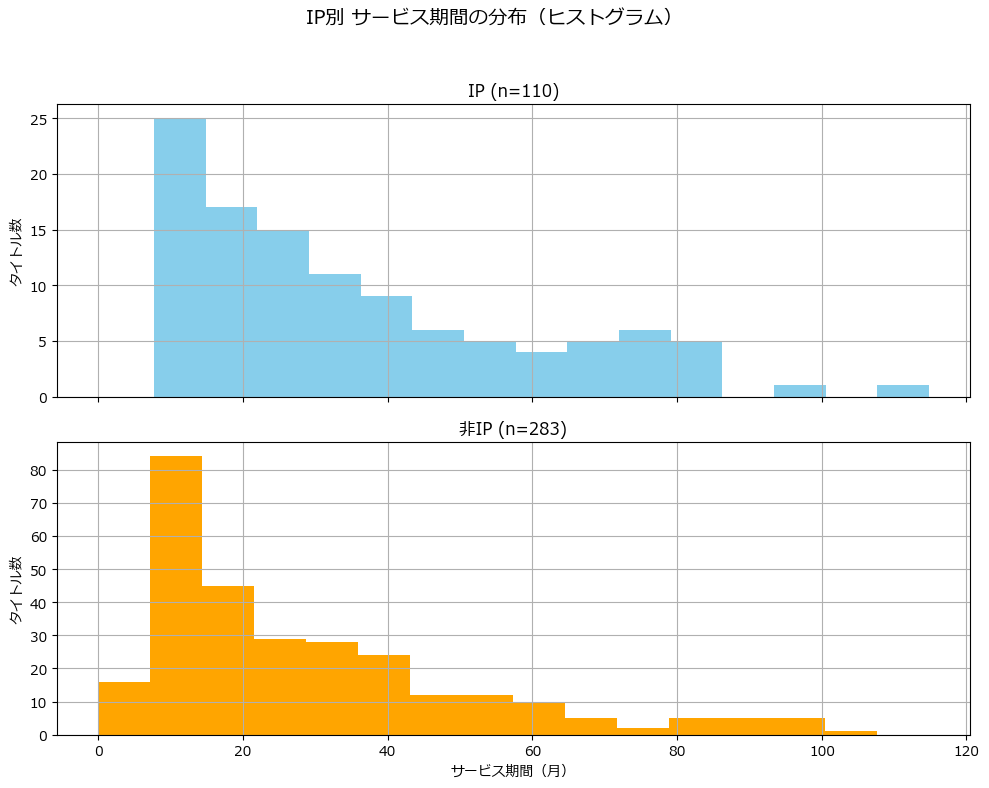

In [20]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8), sharex=True)

for ax, label in zip(axes, ["IP", "非IP"]):
    subset = aggregated[aggregated["IP分類"] == label]
    ax.hist(subset["サービス期間（月）"], bins=15, color="skyblue" if label == "IP" else "orange")
    ax.set_title(f"{label} (n={len(subset)})")
    ax.set_ylabel("タイトル数")
    ax.grid(True)

axes[-1].set_xlabel("サービス期間（月）")
plt.suptitle("IP別 サービス期間の分布（ヒストグラム）", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
